In [21]:
from emir import (GANDeficiencyArgs,GANDeficiencyEstimator, GANTrickedDeficiencyEstimator, WassersteinDeficiencyEstimator, WassersteinGPDeficiencyEstimator)
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn as sk
from sklearn.datasets import make_blobs

from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches

# create logger
import logging
logging.basicConfig(level=logging.INFO)


In [30]:

X = make_blobs(n_samples=10000, n_features=8, centers=6, cluster_std=5.0, center_box=(-50, 50), shuffle=True, random_state=None)


In [31]:
X[1]

array([2, 4, 2, ..., 3, 3, 5])

In [32]:
# Make pca 

pca = PCA(n_components=8)
X_pca = pca.fit_transform(X[0])
labels = X[1]

df = pd.DataFrame(X_pca)
df['labels'] = labels


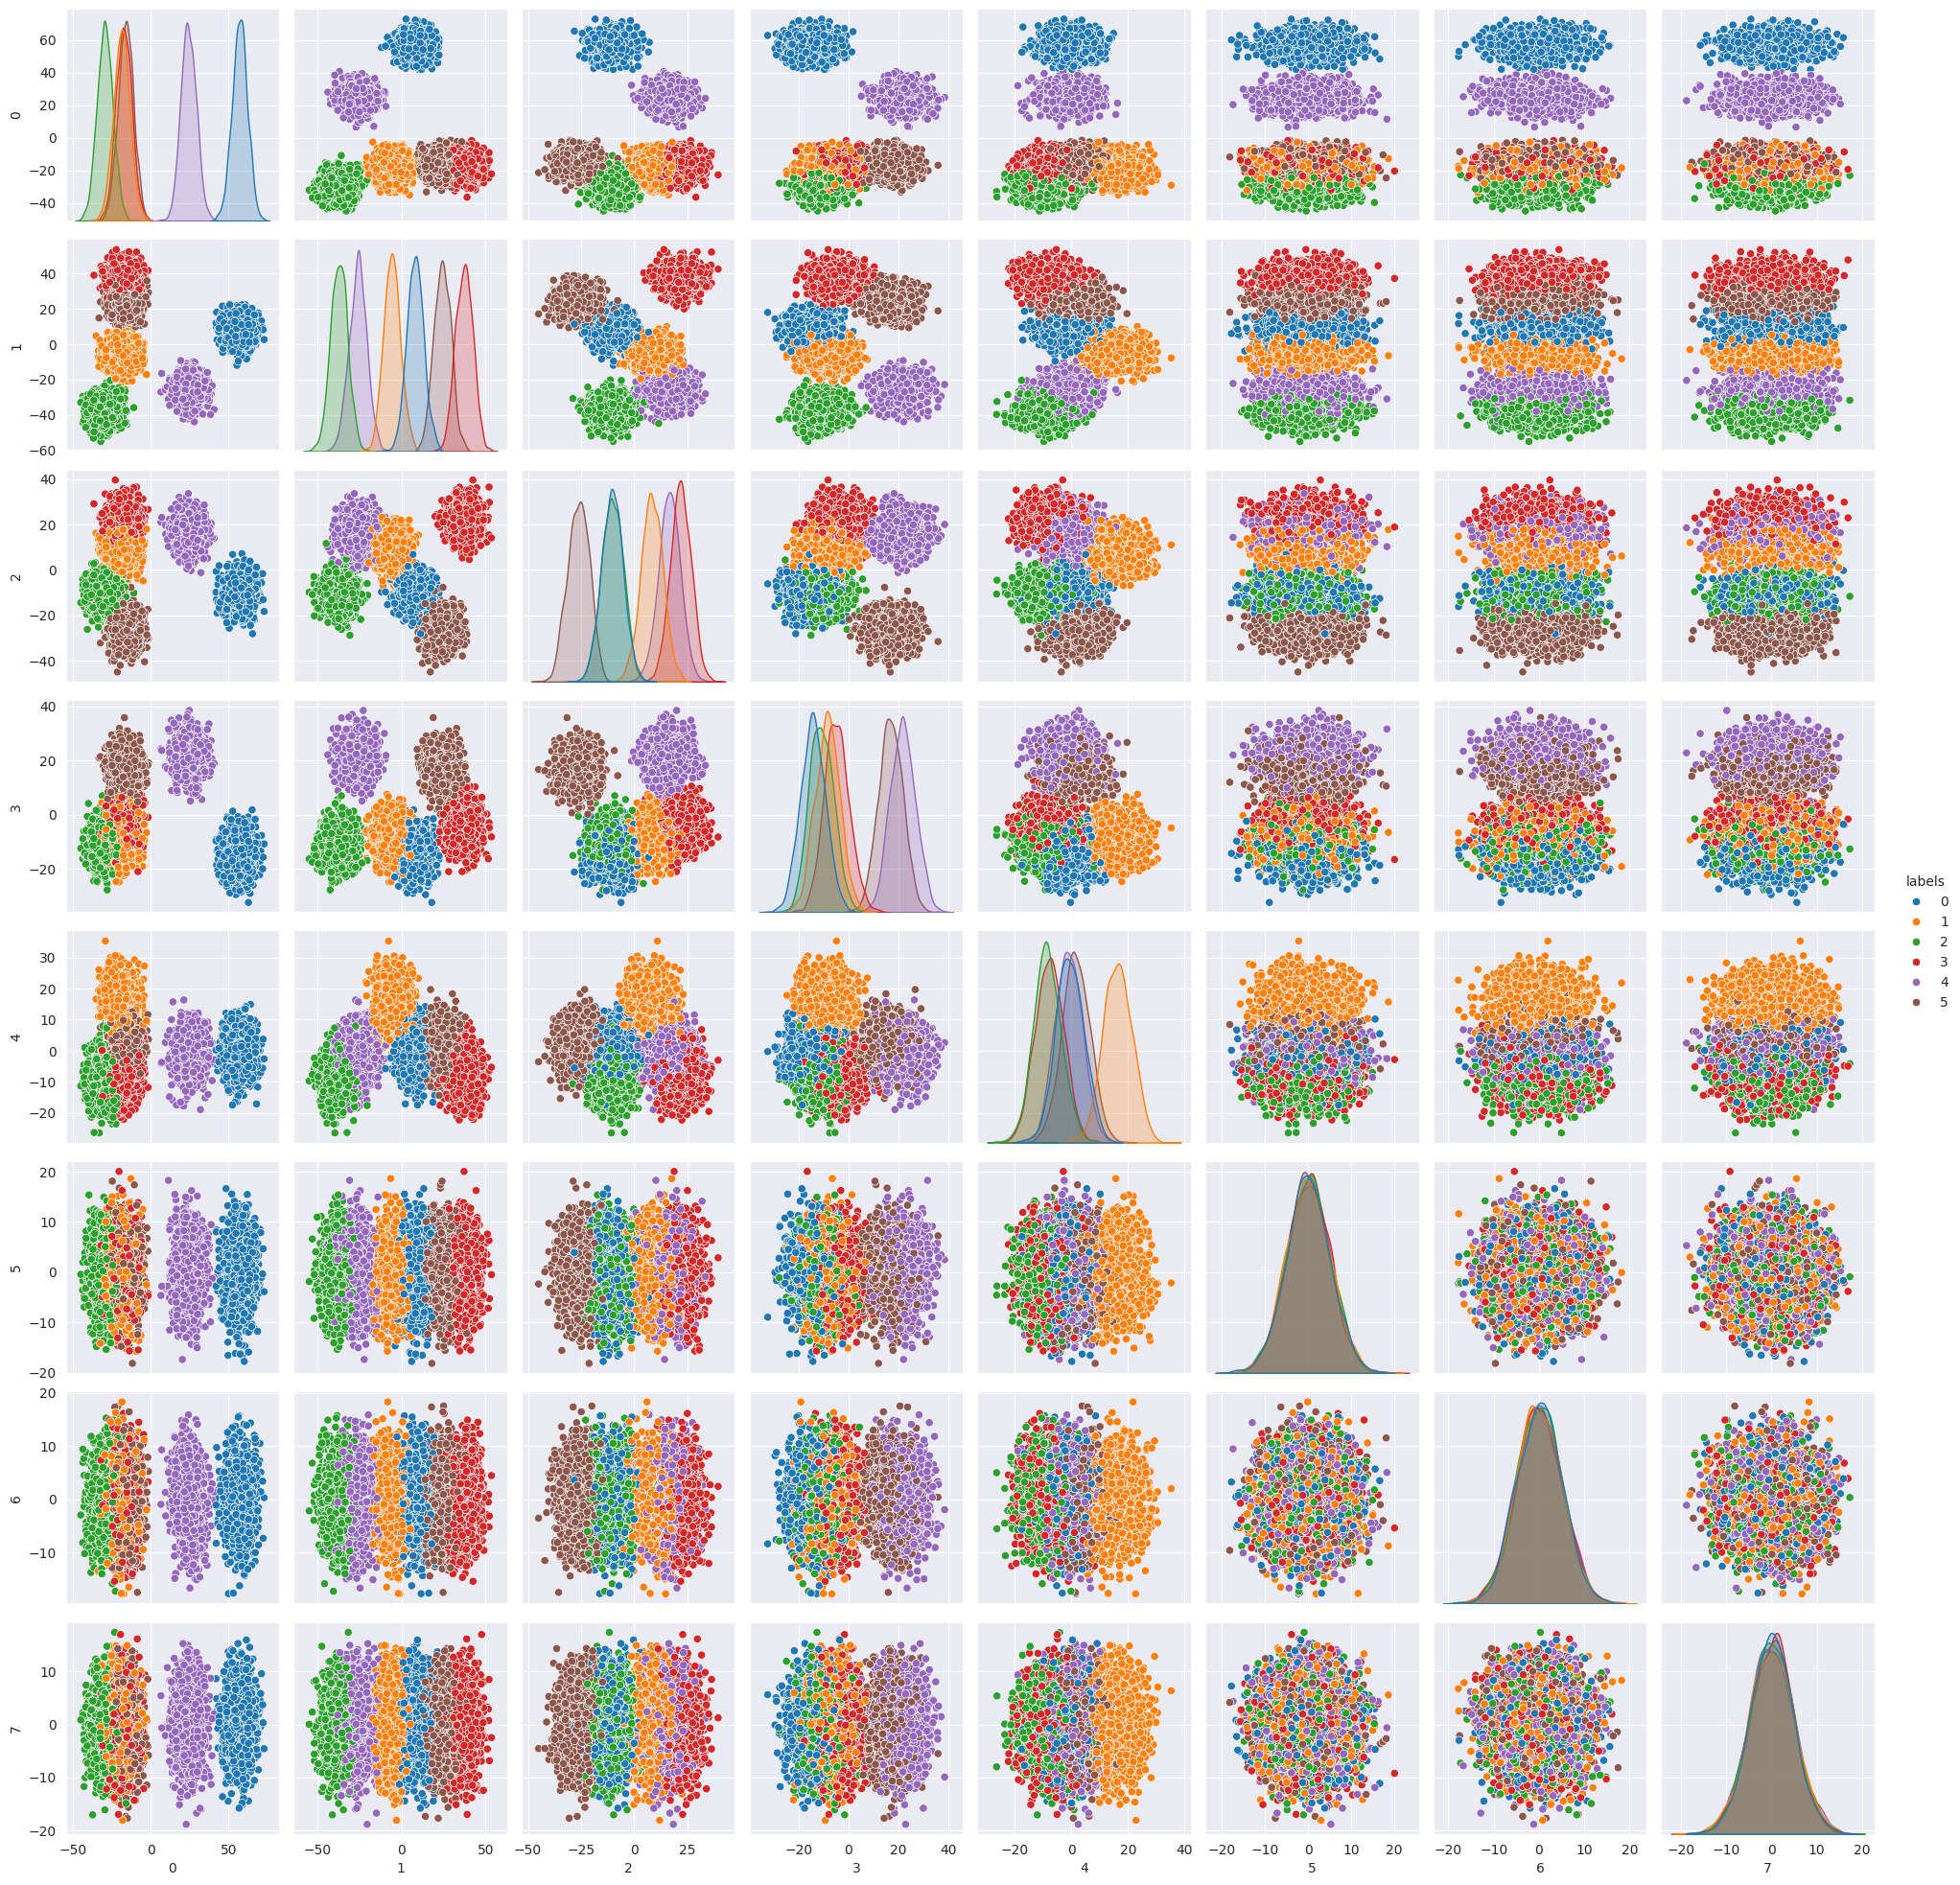

In [33]:

sns.pairplot(df, hue='labels', palette='tab10')


In [36]:

# For each pair get the explained variance

explained_variance = pca.explained_variance_ratio_

def get_projection(X_pca, pca, i, j):
    return X_pca[:, [i, j]], pca.explained_variance_ratio_[i] + pca.explained_variance_ratio_[j]



def evaluate_deficiency(U, Z):

    args = GANDeficiencyArgs(device='cpu',
                             disc_clip=0.01,
                             gen_hidden_dim=8,
                             gen_n_layers=5,
                             critic_n_layers=3,
                             critic_hidden_dim=8,
                             critic_repeats=5,
                             gan_n_epochs=100,
                             gen_lr=2e-4,
                             critic_lr=2e-4,
                             gan_batch_size=64,
                             )
    estimator = WassersteinGPDeficiencyEstimator(args, x_dim=2, y_dim=8)


    results = []

    for _ in range(1):
        estimator.fit_estimator(U, Z)
        Zchap = estimator.gen(U)
        results.append(Zchap.detach().numpy())

    deficiency = estimator.batch_eval(U, Z).item()

    return estimator, results, deficiency



In [37]:

records = []
estimators = []
results_list = []
for i in range(7):
    for j in range(i+1, 8):
        U, explained_var = get_projection(X_pca, pca, i, j)
        Z = X[0]
        Z, U = torch.tensor(Z).float(), torch.tensor(U).float()
        estimator, results, deficiency = evaluate_deficiency(U, Z)
        estimators.append(estimator)
        results_list.append(results)
        
        records.append({'i': i, 'j': j, 'explained_var': explained_var, 'deficiency': deficiency})

df = pd.DataFrame(records)

INFO:emir.estimators.deficiency_estimator:Epoch 1/100, Critic loss: -91.0260238647461, Generator loss: -24.49588966369629
INFO:emir.estimators.deficiency_estimator:Epoch 2/100, Critic loss: -139.93212890625, Generator loss: -9.740032196044922
INFO:emir.estimators.deficiency_estimator:Epoch 3/100, Critic loss: -109.7342529296875, Generator loss: -3.2167258262634277
INFO:emir.estimators.deficiency_estimator:Epoch 4/100, Critic loss: -87.5008316040039, Generator loss: -3.470876693725586
INFO:emir.estimators.deficiency_estimator:Epoch 5/100, Critic loss: -79.97100830078125, Generator loss: -7.917768955230713
INFO:emir.estimators.deficiency_estimator:Epoch 6/100, Critic loss: -67.66990661621094, Generator loss: -9.843450546264648
INFO:emir.estimators.deficiency_estimator:Epoch 7/100, Critic loss: -64.06782531738281, Generator loss: -12.104825019836426
INFO:emir.estimators.deficiency_estimator:Epoch 8/100, Critic loss: -48.7353515625, Generator loss: -7.127058506011963
INFO:emir.estimators.d

<Axes: xlabel='explained_var', ylabel='deficiency'>

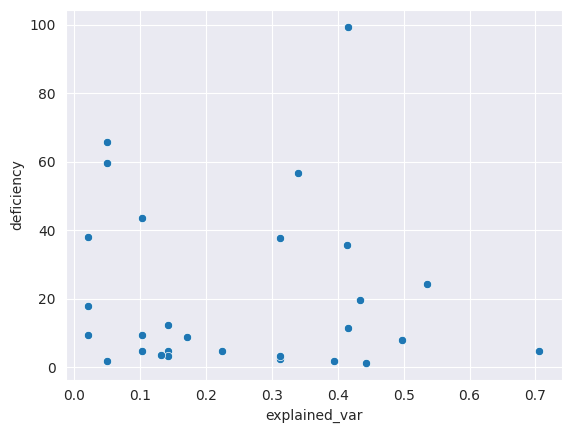

In [38]:
# plot explained variance vs deficiency
sns.scatterplot(data=df, x='explained_var', y='deficiency')